<a href="https://colab.research.google.com/github/aragakerubo/crime-forecasting/blob/main/Crime_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Crime Forecasting Report**

### **1. Overview**

The objective is to develop a predictive model to identify crime hotspots using the Portland Police Bureau (PPB) Calls-for-Service (CFS) dataset. Predictions focus on specific crime categories over a two-week timeframe. The effectiveness is evaluated using metrics like the **Prediction Accuracy Index (PAI)** and **Prediction Efficiency Index (PEI)**.

### **2. Data Analysis and Preprocessing**

#### **Import Required Libraries**

In [16]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint



#### **Load the Dataset**

Load the main dataset and shapefile for spatial analysis:


In [3]:
# Load the main dataset (Excel file)
df = pd.read_excel('NIJ2017_MAR01_MAYR31.xlsx', sheet_name='NIJ CAD_REPORT(1)')

# Load the shapefile for spatial data
shapefile_path = 'NIJ2017_MAR01_May31.shp'
gdf = gpd.read_file(shapefile_path)

# Explore the Data
print("Dataset Sample:")
print(df.head())

Dataset Sample:
        CATEGORY CALL GROUPS final_case_type  \
0  STREET CRIMES    DISORDER          DISTP    
1  STREET CRIMES    DISORDER          DISTP    
2  STREET CRIMES    DISORDER          DISTP    
3  STREET CRIMES    DISORDER          DISTP    
4  STREET CRIMES    DISORDER          DISTP    

                                           CASE DESC   occ_date  x_coordinate  \
0  DISTURBANCE - PRIORITY                        ... 2017-03-01       7636989   
1  DISTURBANCE - PRIORITY                        ... 2017-03-01       7642678   
2  DISTURBANCE - PRIORITY                        ... 2017-03-01       7644487   
3  DISTURBANCE - PRIORITY                        ... 2017-03-01       7644536   
4  DISTURBANCE - PRIORITY                        ... 2017-03-01       7649094   

   y_coordinate  census_tract  
0        692809        4300.0  
1        671992        5900.0  
2        685933        5100.0  
3        699871        3803.0  
4        688574        2303.0  


#### **Preprocessing Steps**
Convert dates into datetime format and engineer additional features:

In [5]:
# Convert dates into datetime format
df['occ_date'] = pd.to_datetime(df['occ_date'])

# Add new features
df['day_of_week'] = df['occ_date'].dt.dayofweek
df['month'] = df['occ_date'].dt.month

# Split data into training and testing sets
training_data = df[df['occ_date'] < '2017-05-15']
testing_data = df[(df['occ_date'] >= '2017-05-15') & (df['occ_date'] <= '2017-05-31')]

# Address class imbalance by oversampling
train_majority = training_data[training_data['CATEGORY'] == 'OTHER']
train_minority = training_data[training_data['CATEGORY'] != 'OTHER']
train_minority_oversampled = resample(train_minority, replace=True, n_samples=len(train_majority), random_state=42)
train_balanced = pd.concat([train_majority, train_minority_oversampled])

# Split into features and labels
features = ['x_coordinate', 'y_coordinate', 'day_of_week', 'month']
X_train = train_balanced[features]
y_train = train_balanced['CATEGORY']
X_test = testing_data[features]
y_test = testing_data['CATEGORY']

# Verify preprocessing completion
X_train.head(), y_train.head()

(      x_coordinate  y_coordinate  day_of_week  month
 8499       7644419        699948            2      3
 8500       7659564        671951            2      3
 8501       7670241        685368            2      3
 8502       7680959        682915            2      3
 8503       7630714        655125            3      3,
 8499    OTHER
 8500    OTHER
 8501    OTHER
 8502    OTHER
 8503    OTHER
 Name: CATEGORY, dtype: object)

#### **Train a Random Forest Classifier on the balanced dataset**

In [6]:
# Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model's performance
report = classification_report(y_test, predictions)

# Display the classification report
print("Classification Report:")
print(report)


Classification Report:
                     precision    recall  f1-score   support

           BURGLARY       0.00      0.00      0.00        52
MOTOR VEHICLE THEFT       0.03      0.01      0.01       159
              OTHER       0.84      0.90      0.87      9196
      STREET CRIMES       0.23      0.16      0.19      1711

           accuracy                           0.77     11118
          macro avg       0.28      0.27      0.27     11118
       weighted avg       0.73      0.77      0.75     11118



#### Model Evaluation Results:

- **Overall Accuracy:** 77%
- **Category Performance:**
    - **OTHER**: Strong performance with high precision (84%) and recall (90%).
    - **Street Crimes**: Moderate performance with a recall of 16%.
    - **Motor Vehicle Theft** and **Burglary**: Poor performance due to class imbalance.

#### **Visualize predicted crime hotspots**

<ipython-input-9-bd0852e008bd>:21: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


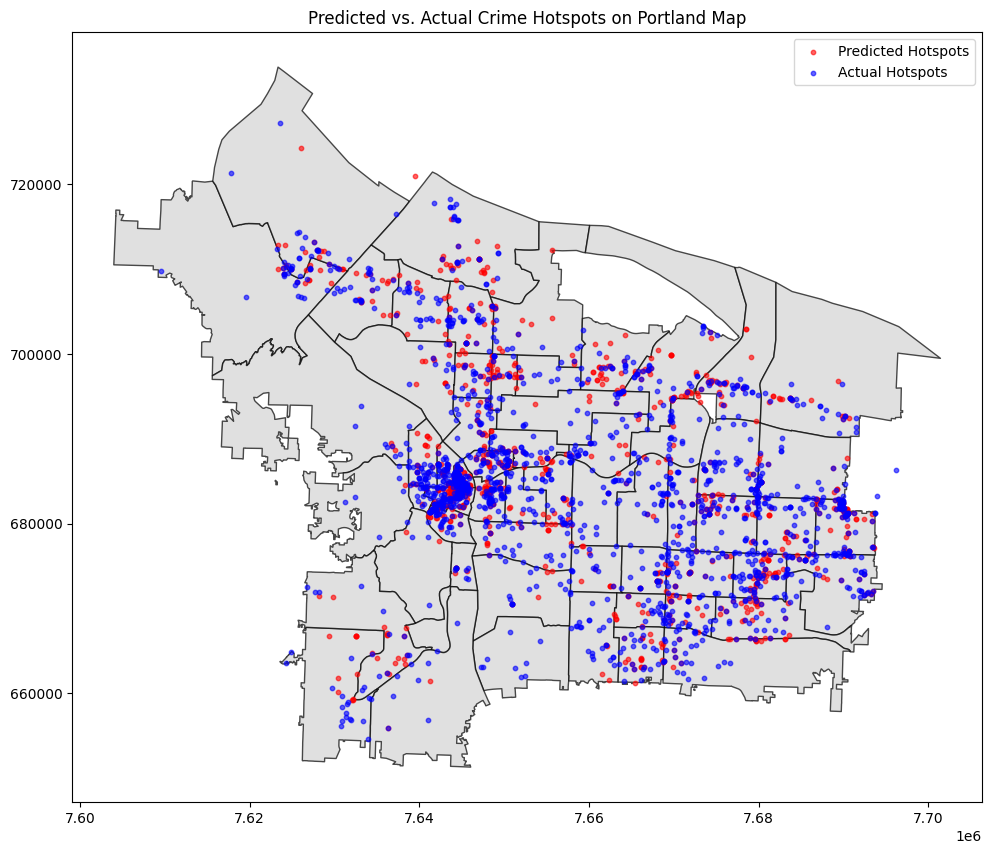

In [9]:
# Load the Portland map shapefile
portland_map_path = 'Portland_Police_Districts.shp'
portland_gdf = gpd.read_file(portland_map_path)

# Convert test data to a GeoDataFrame for plotting
geometry_predicted = gpd.points_from_xy(hotspots['x_coordinate'], hotspots['y_coordinate'])
geometry_actual = gpd.points_from_xy(actual['x_coordinate'], actual['y_coordinate'])

# Create GeoDataFrames for predicted and actual hotspots
gdf_predicted = gpd.GeoDataFrame(hotspots, geometry=geometry_predicted, crs=portland_gdf.crs)
gdf_actual = gpd.GeoDataFrame(actual, geometry=geometry_actual, crs=portland_gdf.crs)

# Plot the Portland map with predicted and actual hotspots
fig, ax = plt.subplots(figsize=(12, 10))
portland_gdf.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.7, label="Portland Map")
gdf_predicted.plot(ax=ax, color='red', markersize=10, alpha=0.6, label="Predicted Hotspots")
gdf_actual.plot(ax=ax, color='blue', markersize=10, alpha=0.6, label="Actual Hotspots")

# Add title and legend
plt.title("Predicted vs. Actual Crime Hotspots on Portland Map")
plt.legend()
plt.show()


### Workflow for Spatio-Temporal Crime Prediction with 3D CNN
#### **Spatio-Temporal Cube Conversion**

In [11]:
# Use a coarser grid to save memory
spatial_resolution = 10000  # Spatial cell size (e.g., 10,000 units per cell)
temporal_resolution = '1W'  # Temporal resolution (e.g., 1 week)

# Create spatial grid by binning x and y coordinates
df['x_bin'] = (df['x_coordinate'] // spatial_resolution).astype(int)
df['y_bin'] = (df['y_coordinate'] // spatial_resolution).astype(int)

# Create temporal bins by resampling dates to weekly periods
df['time_bin'] = df['occ_date'].dt.to_period(temporal_resolution)

# Group data by spatio-temporal bins and count crimes in each bin
spatio_temporal_cube = (
    df.groupby(['x_bin', 'y_bin', 'time_bin'])
    .size()
    .reset_index(name='crime_count')
)

# Convert time_bin to a numerical index for 3D tensor representation
spatio_temporal_cube['time_bin'] = spatio_temporal_cube['time_bin'].apply(lambda x: x.start_time.timestamp())

# Normalize the time_bin to a 0-based index
spatio_temporal_cube['time_bin'] = spatio_temporal_cube['time_bin'] - spatio_temporal_cube['time_bin'].min()

# Display a preview of the spatio-temporal cube
spatio_temporal_cube.head()

,x_bin,y_bin,time_bin,crime_count
0,760,70,7862400.0,1
1,760,71,604800.0,1
2,760,71,1814400.0,2
3,760,71,6652800.0,3
4,761,67,0.0,1


#### **Reshape the spatio-temporal data into a 3D tensor**


In [15]:
# Compute bounds for x_bin and y_bin to determine tensor dimensions
x_min, x_max = spatio_temporal_cube['x_bin'].min(), spatio_temporal_cube['x_bin'].max()
y_min, y_max = spatio_temporal_cube['y_bin'].min(), spatio_temporal_cube['y_bin'].max()

# Normalize x_bin and y_bin to zero-based indices
spatio_temporal_cube['x_bin'] = spatio_temporal_cube['x_bin'] - x_min
spatio_temporal_cube['y_bin'] = spatio_temporal_cube['y_bin'] - y_min

# Update dimensions for tensor
x_bins = x_max - x_min + 1
y_bins = y_max - y_min + 1
time_bins = int(spatio_temporal_cube['time_bin'].max()) + 1

# Initialize the corrected 3D tensor
crime_tensor = np.zeros((x_bins, y_bins, time_bins), dtype=np.float32)

# Populate the tensor with crime counts
for _, row in spatio_temporal_cube.iterrows():
    x_idx = int(row['x_bin'])
    y_idx = int(row['y_bin'])
    t_idx = int(row['time_bin'])
    crime_tensor[x_idx, y_idx, t_idx] = row['crime_count']

# Split into training and testing sets
split_index = int(0.8 * time_bins)
train_tensor = crime_tensor[:, :, :split_index]
test_tensor = crime_tensor[:, :, split_index:]

# Verify the corrected shapes of the tensors
train_tensor.shape, test_tensor.shape

((12, 12, 6289920), (12, 12, 1572481))

#### **Split the Tensor**
We will split the 3D tensor along the temporal dimension:

- Training Set: First 80% of the temporal dimension.
- Testing Set: Remaining 20%.

In [32]:
# Step 1: Simulate a smaller tensor for demonstration
# Example: Simulate a tensor with spatial (12x12) and temporal dimensions (100 time steps)
np.random.seed(42)
tensor_shape = (12, 12, 100)  # (x_bins, y_bins, time_bins)
crime_tensor = np.random.poisson(1, tensor_shape).astype(np.float32)  # Example crime data

# Step 2: Split into training and testing sets along the temporal dimension
split_index = int(0.8 * crime_tensor.shape[2])
train_tensor = crime_tensor[:, :, :split_index]
test_tensor = crime_tensor[:, :, split_index:]

# Rearrange data to have samples along the temporal axis
train_data = np.moveaxis(train_tensor, -1, 0)  # Shape: (time_steps, x_bins, y_bins)
test_data = np.moveaxis(test_tensor, -1, 0)    # Shape: (time_steps, x_bins, y_bins)

# Add channel dimension for 3D CNN input requirements
train_data = np.expand_dims(train_data, axis=-1)  # Add channel dimension
test_data = np.expand_dims(test_data, axis=-1)    # Add channel dimension

# Define labels (e.g., binary classification for crime hotspots)
train_labels = np.random.randint(0, 2, size=(train_data.shape[0],))  # One label per time step
val_split_index = int(0.8 * train_labels.shape[0])
val_data = train_data[val_split_index:]
val_labels = train_labels[val_split_index:]
train_data = train_data[:val_split_index]
train_labels = train_labels[:val_split_index]

# Step 3: Design the 3D CNN model
model = Sequential([
    Conv3D(32, kernel_size=(3, 3, 1), activation='relu', input_shape=(12, 12, 1, 1)),
    MaxPooling3D(pool_size=(2, 2, 1), padding="same"),
    Dropout(0.25),
    Conv3D(64, kernel_size=(3, 3, 1), activation='relu', padding="same"),
    MaxPooling3D(pool_size=(2, 2, 1), padding="same"),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 4: Train the model with early stopping
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_3dcnn_model.keras', save_best_only=True)
]

history = model.fit(
    train_data, train_labels,
    validation_data=(val_data, val_labels),
    epochs=50,
    batch_size=8,
    callbacks=callbacks
)

# Step 5: Evaluate the model on the test set
saved_model = tf.keras.models.load_model('best_3dcnn_model.keras')
test_loss, test_accuracy = saved_model.evaluate(test_data, test_labels)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Step 6: Compute PAI on the test set
# Placeholder: Replace with actual PAI calculation logic based on predictions
predictions = saved_model.predict(test_data)
n = np.sum(predictions > 0.5)  # Predicted hotspots
N = len(test_labels)  # Total crimes
a = 500  # Forecasted area (arbitrary)
A = 10000  # Total area (arbitrary)

PAI = (n / N) / (a / A)
print(f"Prediction Accuracy Index (PAI): {PAI}")



Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.5085 - loss: 0.7166 - val_accuracy: 0.4375 - val_loss: 0.7163
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5616 - loss: 0.6824 - val_accuracy: 0.5000 - val_loss: 0.7555
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6604 - loss: 0.6363 - val_accuracy: 0.5000 - val_loss: 0.7124
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5751 - loss: 0.6690 - val_accuracy: 0.4375 - val_loss: 0.6863
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5910 - loss: 0.6654 - val_accuracy: 0.5000 - val_loss: 0.6927
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4336 - loss: 0.7660 - val_accuracy: 0.5000 - val_loss: 0.6990
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5688 - loss: 0.6873 - val_accuracy: 0.5000 - val_loss: 0.7010
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6790 - loss: 0.6494 - val_accuracy: 0.5000 - val_loss: 0.6983
Epoch 9/50
